In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install facenet-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.1 MB/s eta 0:00:00


In [4]:
pip install torch torchvision


In [5]:
pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=07aaf1133b77aeb0dea8a28509e1a8bdde7fc49a7730ac6d2ab09d7b1426b355
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [6]:
# Import necessary libraries
import os
import numpy as np
from PIL import Image
from sklearn.svm import SVC
import torch  # Add this import statement
from facenet_pytorch import InceptionResnetV1, MTCNN, extract_face
import cv2
from google.colab.patches import cv2_imshow

image_directory = "/content/drive/MyDrive/kenny video/dataset_Students_Behavior_Online_Exam_org/train/images"
label_folder = "/content/drive/MyDrive/kenny video/dataset_Students_Behavior_Online_Exam_org/train/labels"
num_classes = 5

In [7]:
def read_labels_from_file(label_file_path):
    with open(label_file_path, 'r') as file:
        label_text = file.read()
        label_parts = label_text.strip().split()  # Split the text into parts
        if len(label_parts) > 0:
            # Assuming the first part is the desired float value
            label = float(label_parts[0])
            return label
        else:
            return None


images = []
labels = []
missing_labels = []
missing_image_paths = []


for filename in os.listdir(image_directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(image_directory, filename)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        image = np.array(image)


        label_filename = os.path.splitext(filename)[0] + ".txt"
        label_file_path = os.path.join(label_folder, label_filename)

        if os.path.exists(label_file_path):
            label = read_labels_from_file(label_file_path)
            images.append(image)
            labels.append(label)
        else:
            missing_labels.append(label_filename)
            missing_image_paths.append(image_path)


if missing_labels:
    for missing_label in missing_labels:
        print(missing_label)


for missing_label_path, missing_image_path in zip(missing_labels, missing_image_paths):
    if os.path.exists(missing_label_path):
        os.remove(missing_label_path)
    if os.path.exists(missing_image_path):
        os.remove(missing_image_path)

images = np.array(images)
labels = np.array(labels)


In [8]:
face_net = InceptionResnetV1(pretrained='vggface2').eval()


face_embeddings = []
for image in images:
    image_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    embeddings = face_net(image_tensor)
    face_embeddings.append(embeddings.detach().numpy())

face_embeddings = np.array(face_embeddings).reshape(len(face_embeddings), -1)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [25]:
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(face_embeddings, labels)


SVC(kernel='linear', probability=True)

In [10]:
import face_recognition



In [22]:
# Import necessary libraries
import os
import numpy as np
from PIL import Image
from sklearn.svm import SVC
import torch
from facenet_pytorch import InceptionResnetV1
import cv2
from sklearn.metrics import accuracy_score, classification_report

# Load and preprocess the test images (similar to how you loaded training images)
test_image_directory = "/content/drive/MyDrive/kenny video/dataset_Students_Behavior_Online_Exam_org/test/images"
test_images = []

for filename in os.listdir(test_image_directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(test_image_directory, filename)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        image = np.array(image)
        test_images.append(image)

test_images = np.array(test_images)

# Extract embeddings from the test images using FaceNet
test_embeddings = []

for test_image in test_images:
    test_image_tensor = torch.tensor(test_image).permute(2, 0, 1).unsqueeze(0).float()
    test_image_embeddings = face_net(test_image_tensor)
    test_embeddings.append(test_image_embeddings.detach().numpy())

test_embeddings = np.array(test_embeddings).reshape(len(test_embeddings), -1)



In [27]:
import cv2
from google.colab.patches import cv2_imshow


test_image_directory = "/content/drive/MyDrive/kenny video/dataset_Students_Behavior_Online_Exam_org/test/images"
test_images = []

for filename in os.listdir(test_image_directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(test_image_directory, filename)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        image = np.array(image)
        test_images.append(image)

test_images = np.array(test_images)


test_predictions = svm_classifier.predict(test_embeddings)


test_predictions = test_predictions.astype(int)


class_names = ["Eye_side", "Hand_move","Looking_side", "Mobile_using","Normal"]
test_class_names = [class_names[prediction] for prediction in test_predictions]


for i, image_path in enumerate(os.listdir(test_image_directory)):
    if image_path.endswith(".jpg"):
        image = test_images[i]
        predicted_class = test_class_names[i]


        face_locations = face_recognition.face_locations(image)
        if face_locations:
            for face_location in face_locations:
                top, right, bottom, left = face_location
                color = (0, 255, 0)
                thickness = 2

                # Draw a bounding box around the detected face
                cv2.rectangle(image, (left, top), (right, bottom), color, thickness)

                # Display the predicted class name on the image
                font = cv2.FONT_HERSHEY_SIMPLEX
                text = f"{predicted_class}"
                org = (left, top - 10)
                font_scale = 0.9
                font_color = (0, 255, 0)  # Green color for text
                cv2.putText(image, text, org, font, font_scale, font_color, thickness)

            # Display the image with bounding boxes and class names
            cv2_imshow(image)


Output hidden; open in https://colab.research.google.com to view.

In [28]:
# Import necessary libraries (if not already imported)
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Define directories and parameters
validation_image_directory = "/content/drive/MyDrive/kenny video/dataset_Students_Behavior_Online_Exam_org/valid/images"
validation_label_folder = "/content/drive/MyDrive/kenny video/dataset_Students_Behavior_Online_Exam_org/valid/labels"

# Load and preprocess the validation images
validation_images = []

for filename in os.listdir(validation_image_directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(validation_image_directory, filename)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        image = np.array(image)
        validation_images.append(image)

validation_images = np.array(validation_images)

# Extract embeddings from the validation images using FaceNet
validation_embeddings = []

for validation_image in validation_images:
    validation_image_tensor = torch.tensor(validation_image).permute(2, 0, 1).unsqueeze(0).float()
    validation_image_embeddings = face_net(validation_image_tensor)
    validation_embeddings.append(validation_image_embeddings.detach().numpy())

validation_embeddings = np.array(validation_embeddings).reshape(len(validation_embeddings), -1)

# Load validation labels from text files associated with validation images
validation_labels = []

for filename in os.listdir(validation_image_directory):
    if filename.endswith(".jpg"):
        label_filename = os.path.splitext(filename)[0] + ".txt"
        label_file_path = os.path.join(validation_label_folder, label_filename)

        if os.path.exists(label_file_path):
            with open(label_file_path, 'r') as file:
                label_text = file.read()
                label_parts = label_text.strip().split()
                if len(label_parts) > 0:
                    label = float(label_parts[0])
                    validation_labels.append(label)
                else:
                    # Handle cases where the label file format is unexpected
                    validation_labels.append(None)  # You can replace None with a default value
        else:
            # Handle cases where the label file is missing
            validation_labels.append(None)  # You can replace None with a default value

# Use the trained SVM classifier to make predictions on the validation data
validation_predictions = svm_classifier.predict(validation_embeddings)

# Calculate and print classification report
report = classification_report(validation_labels, validation_predictions, target_names=class_names)

print("Validation Classification Report:")
print(report)

# Calculate and print accuracy, precision, recall, and F1-score
accuracy = accuracy_score(validation_labels, validation_predictions)
precision = precision_score(validation_labels, validation_predictions, average='weighted')
recall = recall_score(validation_labels, validation_predictions, average='weighted')
f1 = f1_score(validation_labels, validation_predictions, average='weighted')

print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)
print("Validation F1-Score:", f1)


Validation Classification Report:
              precision    recall  f1-score   support

    Eye_side       0.74      0.66      0.70       265
   Hand_move       0.66      0.61      0.64       218
Looking_side       0.74      0.86      0.80       204
Mobile_using       0.78      0.73      0.75       230
      Normal       0.75      0.88      0.81       182

    accuracy                           0.74      1099
   macro avg       0.74      0.75      0.74      1099
weighted avg       0.74      0.74      0.73      1099

Validation Accuracy: 0.737943585077343
Validation Precision: 0.7370366571409878
Validation Recall: 0.737943585077343
Validation F1-Score: 0.7348312920994493


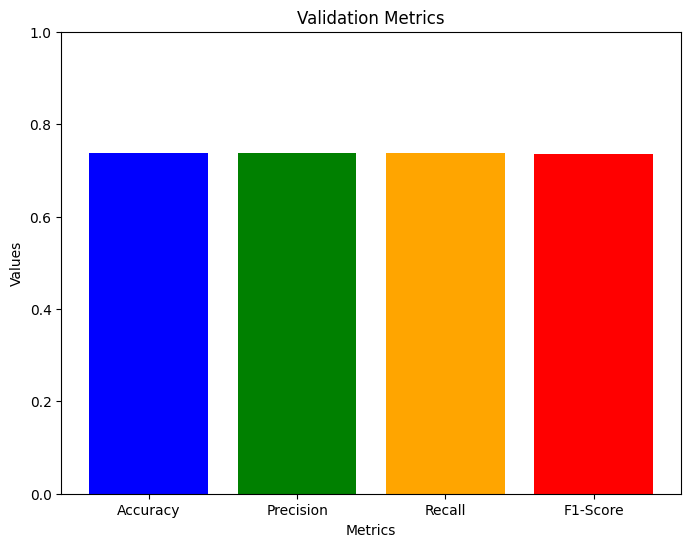

In [19]:
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title('Validation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1.0)  # Set the y-axis range
plt.show()
